
# Predict Steph Curry's Shots 🏀

For this project, I used a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

I created a model to predict whether Curry will make a shot based on his past perfomance.

# Reading and splitting data

To begin with, I imported all required libraries and then read the data in and began to wrangle the data by setting the index to the game date and formatting it as a DateTime object. I then printed the first 15 rows of the dataset to be able to get a better idea of the next best steps.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'] ,index_col=['game_date'])

df.head(15)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,GSW,HOU,Regular Season,4.0
2009-10-28,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,GSW,HOU,Regular Season,-9.0
2009-10-28,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,GSW,HOU,Regular Season,-6.0
2009-10-28,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,GSW,HOU,Regular Season,-9.0


Next, I engineered three new features in order to better visualise the data and give better predictions. These new features included:
- `['homecourt_adv']`: Is the home team (`htm`) the Golden State Warriors (`GSW`)?
- `['sec_remain_in_period]`: How many seconds remain in a given period.
- `['sec_remain_in_game]`: How many seconds remain in a given game.

I then printed the first 5 rows of the dataset to ensure that the new features integrated correctly and did not cause any issues to the rest of the information.

In [4]:
df['homecourt_adv'] = df['htm'] == 'GSW'
df['sec_remain_in_period'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
df['sec_remain_in_game'] = df['period'] * 60 * 12 + df['sec_remain_in_period']

In [5]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_adv,sec_remain_in_period,sec_remain_in_game
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,99,249,0,GSW,HOU,Regular Season,2.0,True,685,1405
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-122,145,1,GSW,HOU,Regular Season,0.0,True,571,1291
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,-60,129,0,GSW,HOU,Regular Season,-4.0,True,362,1082
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,-172,82,0,GSW,HOU,Regular Season,-4.0,True,589,2029
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-68,148,0,GSW,HOU,Regular Season,0.0,True,139,1579


Then, I divided the DataFrame `df` into the feature matrix `X` and the target vector `y`, using the target column `shot_made_flag`.

After dividing the data, I could then split my dataset into training, validation, and testing sets. I chose to use a date cutoff method to split my data.

I printed the last 5 rows of my new `X_train` dataset to make sure that my target column was not present, and to ensure that the date cutoff was in the correct position.

In [6]:
X = df.drop(columns='shot_made_flag')
y = df['shot_made_flag']

In [7]:
train_end = '2017-06-12'
val_end = '2018-06-08'
test_end = '2019-06-05'

val_start = '2017-10-01'
test_start = '2018-10-01'

X_train = X.loc[:train_end]
y_train = y.loc[:train_end]
X_val = X.loc[val_start:val_end]
y_val = y.loc[val_start:val_end]
X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

In [8]:
X_train.tail()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot,homecourt_adv,sec_remain_in_period,sec_remain_in_game
game_date,,,,,,,,,,,,,,,,,,,,,
2017-06-12,41600405,500,Stephen Curry,4,4,32,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,0,0,8,GSW,CLE,Playoffs,10.0,True,272,3152
2017-06-12,41600405,503,Stephen Curry,4,4,13,Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,1,-7,11,GSW,CLE,Playoffs,12.0,True,253,3133
2017-06-12,41600405,527,Stephen Curry,4,1,37,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),...,28,1,283,GSW,CLE,Playoffs,11.0,True,97,2977
2017-06-12,41600405,534,Stephen Curry,4,0,42,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),...,26,-166,205,GSW,CLE,Playoffs,11.0,True,42,2922
2017-06-12,41600405,536,Stephen Curry,4,0,20,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),...,23,235,7,GSW,CLE,Playoffs,12.0,True,20,2900


# Establish Baseline

I established the baseline accuracy score for this classification problem using the training set. I then saved the score to the variable `baseline_acc`.

In [9]:
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


# Build Model

Next, I built a model that included a ordinal encoder for categorical features and a random forest classifier. I then combined these components as well as an imputer to fill any missing values using a pipeline. I then fit the pipeline using the training dataset and checked the feature importances of the various columns to adjust for any potential leakage.

In [10]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=5, n_jobs=-1, max_depth=5, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
P...
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=5, n_jobs=-1,
                                        random_state=42))])

<Axes: >

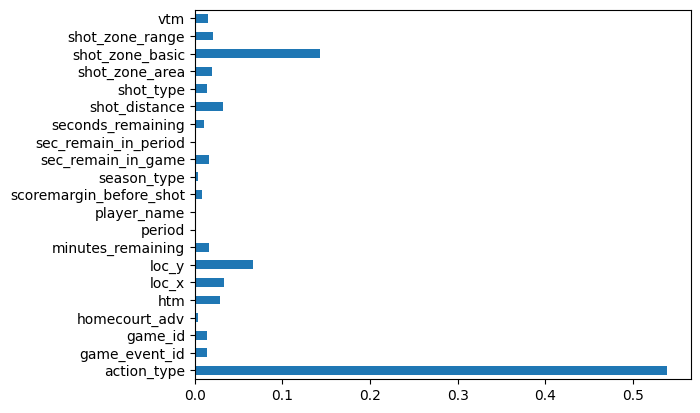

In [11]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index = features).sort_index().tail(50).plot(kind='barh')

I then checked the training and validation accuracy of my model, and asssigned the scores to `train_acc` and `val_acc` for further analysis.

In [12]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.6545438137352224
Validation Accuracy Score: 0.6001712328767124


#Tune Model
Now that I had a base model set, I began to tune the hyperparameters using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and checking my values in order to improve the accuracy of my model.

In [16]:
clf=make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    )

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': (5,40,5)
}

model_rscv = RandomizedSearchCV(clf, param_grid, n_iter=3, cv=None, n_jobs=-1, verbose=1)

model_rscv.fit(X_train, y_train);

print(model_rscv.best_params_)
print('')
print(model_rscv.best_score_)
print('')
print(model_rscv.best_estimator_)
print('')

print(model_rscv.score(X_val, y_val))
print('')

test_acc = model_rscv.score(X_test, y_test)

print('Testing Accuracy Score:', test_acc)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 5, 'randomforestclassifier__max_depth': 15}

0.6028331696816037

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot

# Communication

To communicate my results, I chose to plot a confusion matrix for my model, and the calculate the precision and recall to check (again) on my accuracy to compare against my baseline.

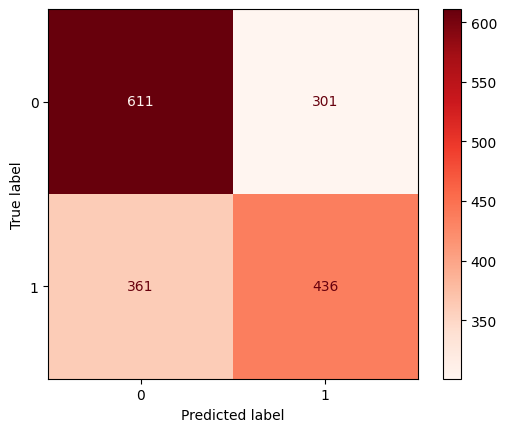

In [14]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

plot_confusion_matrix(model, X_test, y_test, cmap='Reds');

In [15]:
model_precision = 436 / (436 + 301)
model_recall = 436 / (436 + 361)

print('Model precision', model_precision)
print('Model recall', model_recall)

Model precision 0.5915875169606513
Model recall 0.5470514429109159
